# Reliability Analysis in Python

## Background

A python version of [Reliability Analysis in R](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/). The aim of this jupyter notebook is to recreate that reliability analysis in python, and therefore many of the results here are compared directly to those in the R script. Most of the explanations have also been adapted. 

This script provides a demonstration of some tools that can be used to conduct a reliability analysis in Python.

# 1. Before starting

## Packages 

To run this notebook, you will need the following python packages installed: [`numpy`](https://numpy.org/), [`matplotlib`](https://matplotlib.org/), [`pandas`](https://pandas.pydata.org/), [`reliability`](https://pypi.org/project/reliability/), [`weibull`](https://pypi.org/project/weibull/),  [`statsmodels`](https://pypi.org/project/statsmodels/), [`scipy`](https://www.scipy.org/) and [`math`](https://docs.python.org/3/library/math.html). Note that the weibull package is being superceded by reliability, which is currently in development.

# 2. This example analysis

In this example script the aim is to demonstrate how reliability analyses can be conducted in R and thus present only some of the analytical tools available.

## Dataset

Presented is an example analysis of a dataset of time-to-failure measurements that includes censored measurements $(n=127)$. Censoring is the process of coding usage (e.g., time) measurements taken where failures have not occurred. For instance, a right-censored observation (or suspension) may occur because the item is still functioning at the time of measurement.

These data represent failures of Ground Engaging Tools (GET) used in hard rock mining excavators. This dataset comes from a single excavator over an 8 year period.

Ground engaging tools attach to the excavator bucket, they are also known as “teeth” due to their similarity in shape to human teeth. There are usually between 5 and 8 teeth on a bucket. GET are designed to wear out and are replaced when they functionally fail. This functional failure is defined by the ability of the tooth to penetrate the rock and power required. Each failure/ suspension event in the data represents the replacement of one or more teeth. The records do not state how many teeth are replaced at each event.

These data were collected as part a mobile mining equipment database described in Ho (2016). Details on the data collection, cleaning and processing are described in Hodkiewicz and Ho (2016).

## Objective

We are interested in estimating some properties of the reliability of a system, or of a component of a system, including predicting the mean time-to-failure (MTTF).

## Analysis models

For simplicity here we assume the distribution of time-to-failure measurements are well approximated by the 2-parameter Weibull distribution. The validity of this assumption, however, is arguable (see below) and we do not recommend making this assumption in all cases. Accordingly, we also present some tools for evaluating the suitability of some alternative parametric distributions (following Meeker & Escobar 1998).

The probability density function $f(t)$ of the 2-parameter Weibull distribution is defined for the random variable $T$, which is the lifetime of a component or system (i.e., where $P[T=t]=f(t)$):

<center>$f(t) = \frac{\beta}{\eta}(\frac{t}{\eta})^{\beta -1}e^{-(\frac{t}{\eta})^{\beta}}$</center>

For reliability analysis, $t$ is some measure of usage (e.g., total operating or running time) and $\beta, \eta$ are “shape” and “scale” parameters, and each can also be interpreted as having a specific meaning (see below).

We use maximum likelihood estimation ( _MLE_ ) to estimate these parameters of the Weibull distribution $(\hat{\beta}, \hat{\eta})$. This, in turn, allows us to estimate the expectation, or centre of mass, of the Weibull probability density function ( _PDF_ ) for $T$, $E[T]$. The estimate of _MTTF_ is then taken as the $E[T]$, as predicted from, and contingent upon the assumptions of, this analysis model. An alternative method for estimating these parameters is from using Median Ranked Regression ( _MRR_ ; e.g., see Abernethy 2003, O’Connor and Kleyner 2012). A recent study by Genschel and Meeker (2010) demonstrated that, for most datasets, MLE was likely to produce more reliable estimates of Weibull parameters than MRR, and that this was consistent with evidence from several other independently published studies. Please refer to Genschel and Meeker (2010) for further details.

We caution, however, that one should always assess appropriate diagnostics to evaluate the validity of model assumptions for every dataset analysed, and acknowledge sources of uncertainty in every new set of results (e.g., see Meeker and Escobar 1998).

# 3. Analyses

## 3.1 Load required packages, functions and dataset

We first need to import the `numpy`, `matplotlib.pyplot`, `pandas`, `reliability`, `weibull `, `statsmodels.distributions.empirical_distribution` , `scipy.stats` and `math` packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import reliability as rb
import weibull as wb
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as st
from math import sqrt

C:\Users\sophi\anaconda3\lib\site-packages\weibull\__init__.py:9: UserWarning: The "weibull" module is being superceded by the "reliability" module and will no longer be maintained. Please refactor your code for this alternative model and thank you for using weibull!
  warnings.warn('The "weibull" module is being superceded by the "reliability" module and will no longer be maintained. '


For further information on each package you can type commands such as `help(wb)`.

Next, we need to load the dataset. Here, we use the `pandas` function _read_csv_ to load the _comma separated values_ (csv) file in as a data frame. 

In [2]:
exa1 = pd.read_csv('https://raw.githubusercontent.com/CodeOwl94/ross-reliability/master/EXA1.csv',
                   header=0)

A csv file can be prepared by saving these data, once appropriately formatted (see below) in an MS Excel worksheet, as this type of file using the _“Save As”_ option, as selected from the _“File”_ menu in Excel. The _header=0_ argument is specified as we wish to retain the appropriately labelled data columns within the data frame object.

**NOTE**: If, after stepping through this example script, you wish to apply these functions to analyse your own dataset, you will need to firstly reformat your data into a .csv file, and then load it into Python, as demonstrated above. However you will need to enter your file name as the first argument of the `pd.read_csv()` function instead. There are other ways of importing data into Python, but if you need more information about this method, type the command `help(pd.read_csv)`.

In [3]:
print(exa1.shape)

(127, 2)


Our data appears to have been read in OK, we know this as the number of rows, 127, and number of columns, 2, match both the <a href="https://raw.githubusercontent.com/CodeOwl94/ross-reliability/master/EXA1.csv">original data set</a> and the <a href="https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/"> R script</a>. 

Always check this, as errors may occur in this step, such as missing values or columns.

Now, lets have a look at the data:

In [4]:
print(exa1['fail'].value_counts())

exa1.head()

F    123
S      4
Name: fail, dtype: int64


,fail,time
0,F,57
1,F,7
2,F,21
3,F,7
4,S,76


Prior to importing this file, we coded the values in the `fail` column as:

- F, _Failure:_ a valid time-to-failure measurement, or
- S, _Suspension:_ a right censored measurement.

None of the packages used require binary coding for `fail` data, however for consistency we will recode the `fail` values such that:

- 1, _Failure:_ a valid time-to-failure measurement, or
- 0, _Suspension:_ a right censored measurement.

In [5]:
exa1.rename(columns={'fail':'event'}, inplace=True)

exa1.event.replace(to_replace='F', value=1, inplace=True)
exa1.event.replace(to_replace='S', value=0, inplace=True)

print(exa1['event'].value_counts())

1    123
0      4
Name: event, dtype: int64


We'll first sort the data by `time`, in ascending order to make it easier to plot.

In [6]:
exa1 = exa1.sort_values(by='time',ignore_index=True, ascending=True)
exa1.head()

,event,time
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3


We'll also create the following dataframes and lists:
- `failures`: A pandas dataframe containing only valid time-to-failure measurements.
- `right_censored`: A pandas dataframe containing only right censored measurements.
- `failure_times`: List of time-to-failure measurements in ascending order
- `right_censored_times`: List of right censored measurements in ascending order

We will use these later in the analysis.

In [7]:
failures = exa1[exa1['event']==1]
right_censored = exa1[exa1['event']==0]

failure_times = failures['time'].values.tolist()
right_censored_times = right_censored['time'].values.tolist()


We'll first sort the data by `time`, in ascending order to make it easier to plot.

In [8]:
exa1 = exa1.sort_values(by='time',ignore_index=True, ascending=True)
exa1.head()

,event,time
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3


## 3.2 Graphical Analysis

Using `matplotlib` we can have an initial look at the data. Importantly, this step helps to understand these data prior to fitting any models or making strong model assumptions (Meeker and Escobar, 1998). Results will inform initial decisions made during subsequent model fitting.

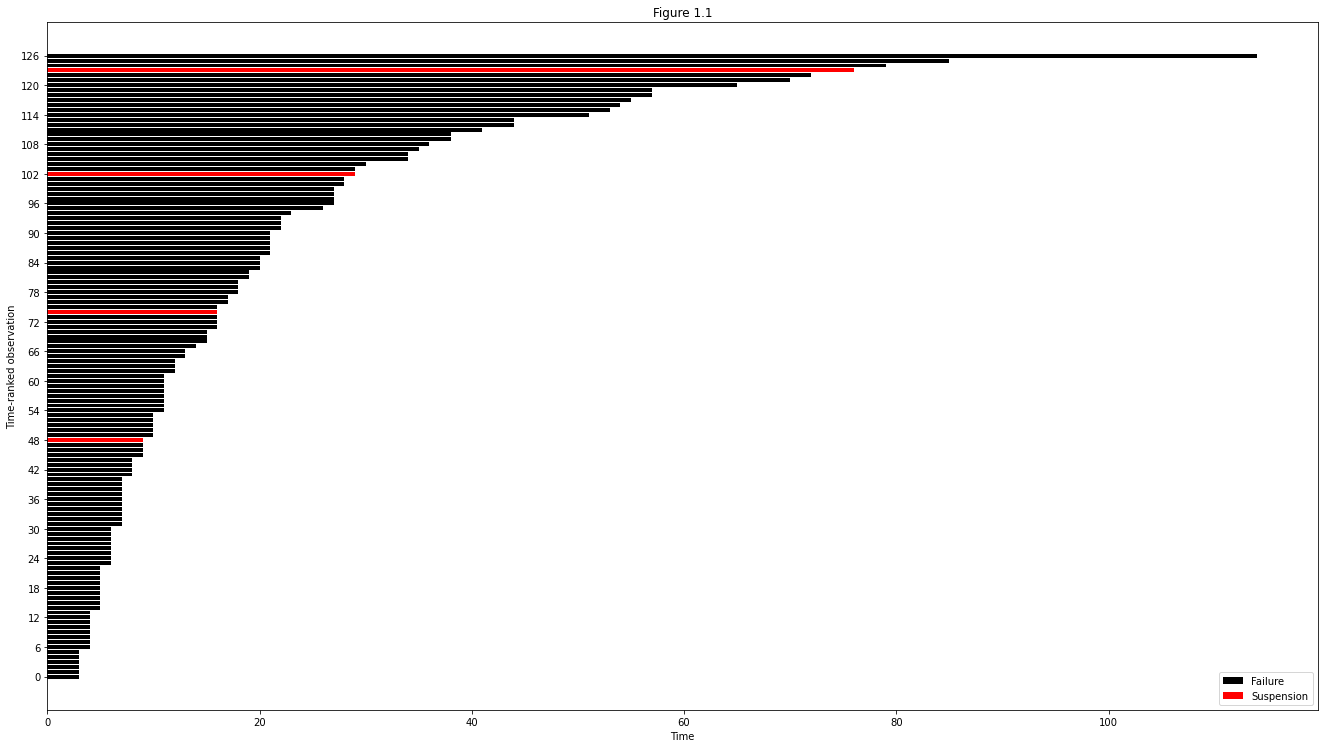

In [9]:
yaxis = np.arange(0, len(exa1), 6)

fig, ax = plt.subplots()

mask1 = exa1['event']==1
mask2 = exa1['event']==0

ax.barh(np.arange(0,len(exa1))[mask1], exa1['time'][mask1], color='black', label='Failure')
ax.barh(np.arange(0,len(exa1))[mask2], exa1['time'][mask2], color='red', label='Suspension')

ax.set_yticks(yaxis)
ax.set_yticklabels(yaxis)
ax.set_xlabel('Time')
ax.set_ylabel('Time-ranked observation')
ax.set_title('Figure 1.1')
ax.legend()
fig.set_size_inches(18.5, 10.5)

plt.show()

This figure shows the sorted raw failure times, with censored time coloured in red. Note that this differs from the [R script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/) in that these data are ordered from low time measurement at the bottom to high time measurement at the top, compared to the inverse in the R script.


This plot is a little difficult to see, so instead we'll look at the first 60 observations:

Plotting the observations ranked 1 to 60, in terms of time measurement we can see the first right-censored measurement occurs at rank 48, along with three other measurements.

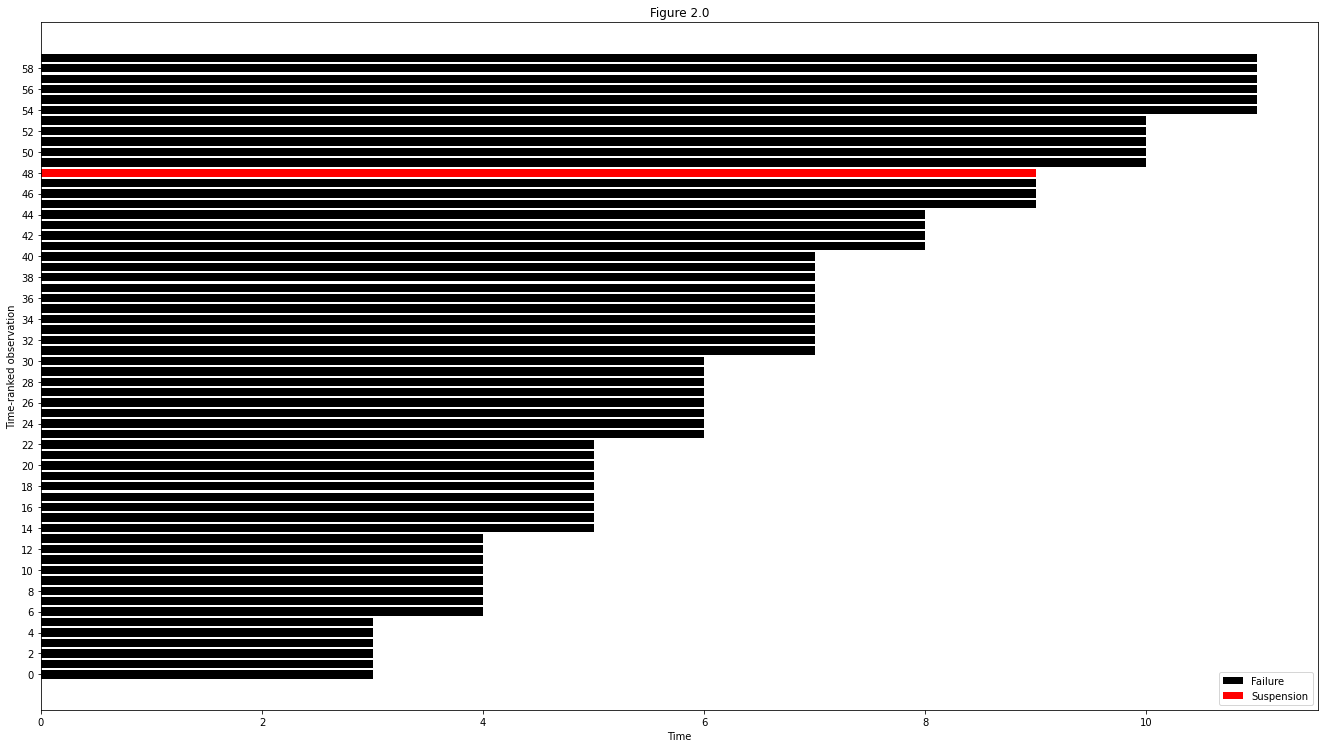

In [10]:
yaxis = np.arange(0, len(exa1[:60]), 2)

fig, ax = plt.subplots()

mask1 = exa1[:60]['event']==1
mask2 = exa1[:60]['event']==0

ax.barh(np.arange(0,len(exa1[:60]))[mask1], exa1[:60]['time'][mask1], 
        color='black', label='Failure')
ax.barh(np.arange(0,len(exa1[:60]))[mask2], exa1[:60]['time'][mask2], 
        color='red', label='Suspension')

ax.set_yticks(yaxis)
ax.set_yticklabels(yaxis)
ax.set_xlabel('Time')
ax.set_ylabel('Time-ranked observation')
ax.set_title('Figure 2.0')
ax.legend()
fig.set_size_inches(18.5, 10.5)

plt.show()

We can see that the first right-censored measurement occurs at the 48th observation (which is tied with 3 other measurements).

Looking at the remaining time measurements (longer operating times), we see that the three other censored measurements occur at ranks 75,  102, and 123.


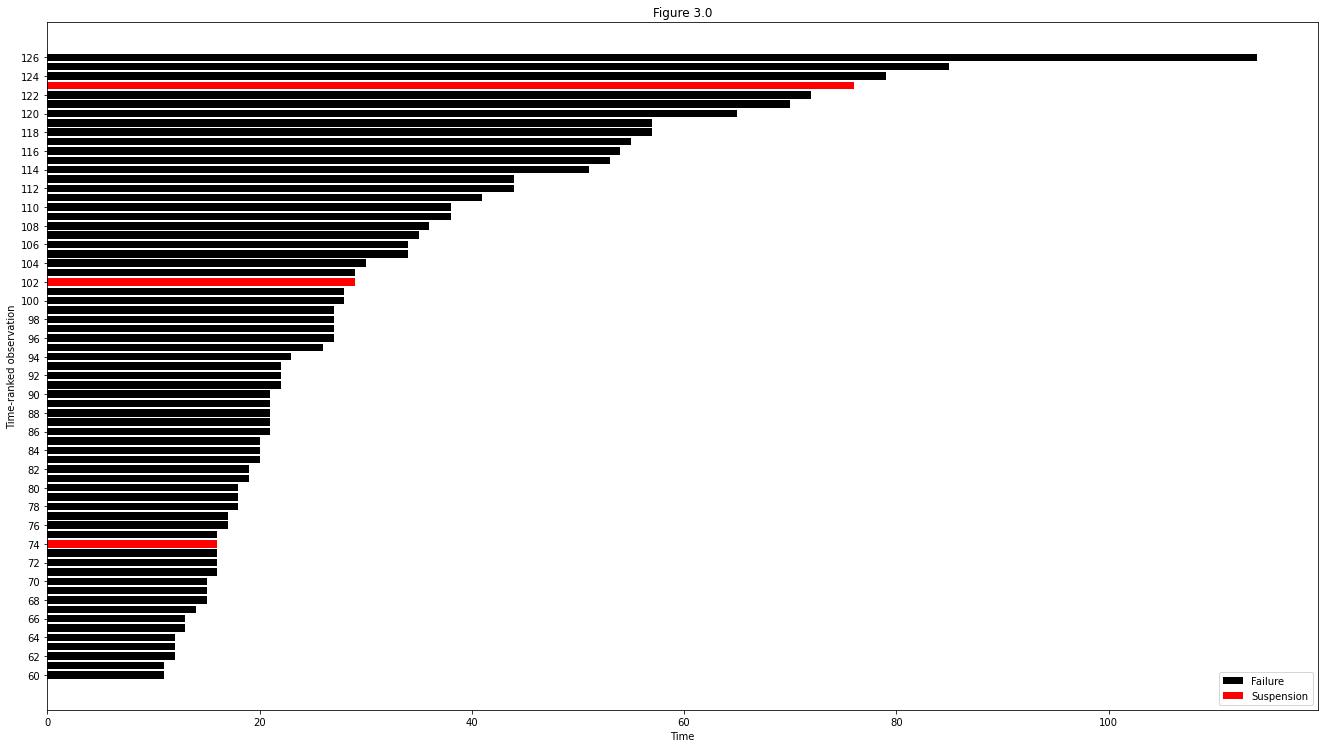

In [11]:
yaxis = np.arange(60, len(exa1), 2)

fig, ax = plt.subplots()

mask1 = exa1[60:]['event']==1
mask2 = exa1[60:]['event']==0

ax.barh(np.arange(60,len(exa1))[mask1], exa1[60:]['time'][mask1], 
        color='black', label='Failure')
ax.barh(np.arange(60,len(exa1))[mask2], exa1[60:]['time'][mask2], 
        color='red', label='Suspension')

ax.set_yticks(yaxis)
ax.set_yticklabels(yaxis)
ax.set_xlabel('Time')
ax.set_ylabel('Time-ranked observation')
ax.set_title('Figure 3.0')
ax.legend()
fig.set_size_inches(18.5, 10.5)

plt.show()

And to verify the ranks:

In [12]:
print(exa1[exa1['event']==0])

     event  time
48       0     9
74       0    16
102      0    29
123      0    76


Note that in the above plots we use the following commands:
- `yaxis = np.arange({start}, len(exa1), {step})` are the values we want for the 'ticks' on the y-axis, such that the values are spaced enough that we can see them.
- `mask{1, 2} = exa1[{start}:{end}]['event']=={1,0}` is so that we can colour the bars based on whether the event value is a failure (1) or suspension (0).
- `ax.set_yticks(yaxis)` sets the ticks on the y-axis to the values specified above. 
- `ax.set_yticklabels(yaxis)` sets the labels of the ticks on the y-axis to the values specified above.

Where {} is a user specified value.

---

Now, we'll have a look at the empirical cumulative frequency distribution of the complete time-to-failure measurements.

In [13]:
ecdf = ECDF(failures['time'])

qtl_25 = failures.quantile(q = 0.25)
qtl_5 = failures.quantile(q = 0.5)
qtl_75 = failures.quantile(q = 0.75)

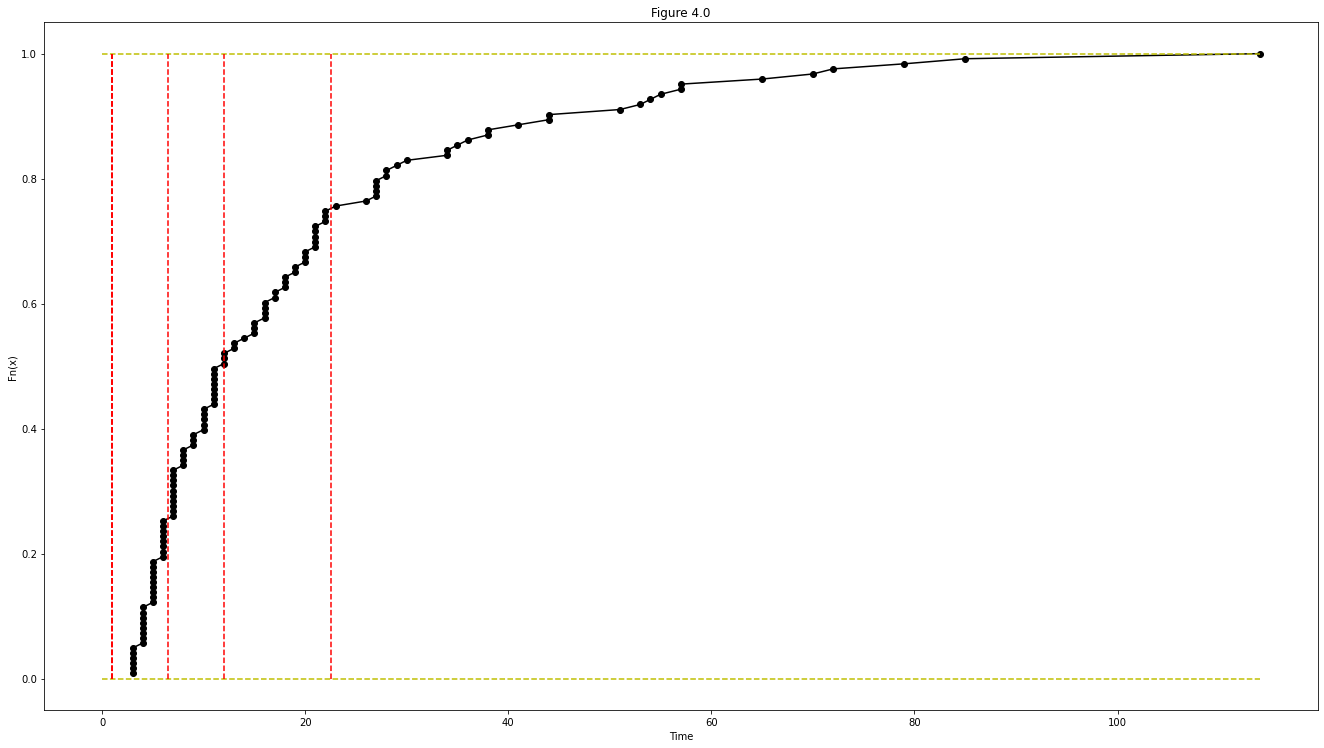

In [14]:
fig, ax = plt.subplots()

plt.plot(ecdf.x, ecdf.y, '-k')
plt.plot(ecdf.x, ecdf.y, 'ok')

### Horizontal Lines at 0 and 1
plt.plot([0, max(failures['time'])], [0,0], '--y')
plt.plot([0, max(failures['time'])], [1,1], '--y')

### Quantile Lines
plt.plot([qtl_25, qtl_25], [0, 1], '--r')
plt.plot([qtl_5, qtl_5], [0, 1], '--r')
plt.plot([qtl_75, qtl_75], [0, 1], '--r')

ax.set_xlabel('Time')
ax.set_ylabel('Fn(x)')
ax.set_title('Figure 4.0')
fig.set_size_inches(18.5, 10.5)

plt.show()

Later, we adjust these relative frequencies for the censored observations to obtain non-parametric estimates of the probability of failure with time, $F(t)$.

Next we can inspect the sampled frequencies as a histogram:

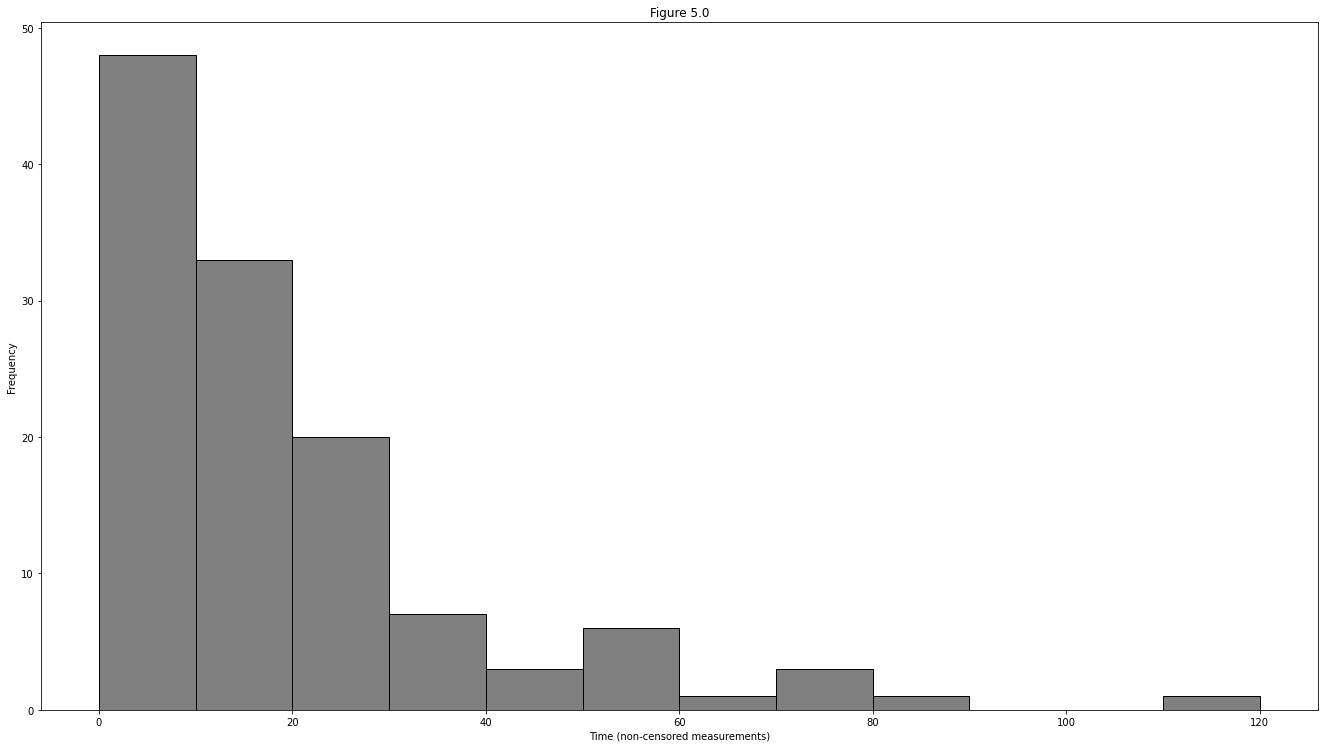

In [15]:
fig, ax = plt.subplots()

bins = np.arange(0, max(failures['time'])+10, 10)
plt.hist(failures['time'], bins=bins, range=(5, max(failures['time'])), 
         color='grey', edgecolor='black')

ax.set_xlabel('Time (non-censored measurements)')
ax.set_ylabel('Frequency')
ax.set_title('Figure 5.0')
fig.set_size_inches(18.5, 10.5)

plt.show()

Right-skewed distributions are typical of reliability data. Are these data from a single distribution? If there are unusual (e.g. multi-modal) patterns it might be worth seeking additional information about how these data were sampled. 

To return the plotted values, we first create a `bin` column in our data frame, and then we can look at the frequencies. 

In [16]:
bins = np.arange(0, max(failures['time'])+10, 10)

failures['binned'] = pd.cut(failures['time'], bins)
failures['binned'].value_counts(sort=False)

(0, 10]       53
(10, 20]      31
(20, 30]      18
(30, 40]       6
(40, 50]       3
(50, 60]       6
(60, 70]       2
(70, 80]       2
(80, 90]       1
(90, 100]      0
(100, 110]     0
(110, 120]     1
Name: binned, dtype: int64

The printed counts shows the sampled frequencies of failure time measurements (column 2) alongside the bin values.

These counts show that the majority of failures (i.e., approximately 85% of non-censored measurements) occurred prior to time 30, with small sample sizes for bins thereafter (and especially after time 60), which should be borne in mind when interpretting results.

Next we construct probability plots, as suggested in Meeker and Escobar (1998), to identify which distribution(s) may provide a good approximation of these data. We can use the `Fit_Everything` function from the reliability package. This function returns parameter estimates, a plot of the CDF and PDF of a distribution against the histogram of failure data, and probability plots. For now, we'll just look at the probability plots and parameter estimates.

Note that the library is in active development and so does not yet have confidence intervals, but we can still however get an initial idea of which distributions the data may follow based on how 'well' they overlay the fitted line. 

Figure 6
                  Alpha      Beta    Gamma       Mu     Sigma     Lambda         AICc          BIC
Distribution                                                                                      
Gamma_3P        31.3709  0.559709   2.9999                                 917.898782   926.236221
Weibull_3P      14.1585  0.718314   2.9999                                 926.723533   935.060972
Exponential_2P                       2.999                     0.0577702   951.512382   957.103982
Lognormal_2P                                2.60439  0.897411              965.320406   970.912006
Lognormal_3P                       2.35205  2.27308   1.21124              956.680233   970.912006
Gamma_2P        14.8246    1.3688                                          985.115912   990.707512
Exponential_1P                                                 0.0490041   989.932004   992.744192
Weibull_2P       21.317   1.12284                                          989.125278   994.716878
N

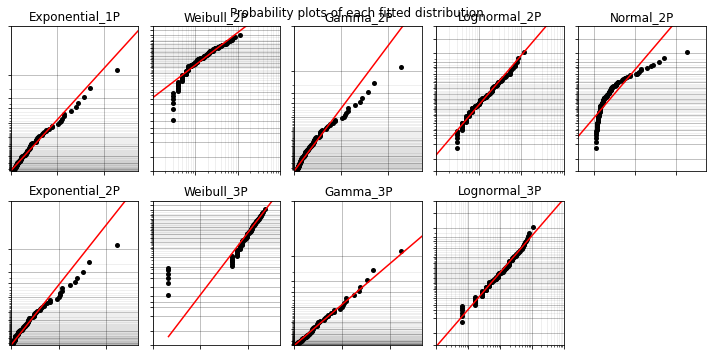

In [17]:
print("Figure 6")
results = rb.Fitters.Fit_Everything(failures=failure_times, 
                                    right_censored=right_censored_times, 
                                    show_histogram_plot=False, show_PP_plot=False)

From the <a href="https://reliability.readthedocs.io/en/latest/Probability%20plots.html#what-does-a-probability-plot-show-me">Reliability docs</a>:

> These probability plots show how well the data is modelled by a particular distribution. The axes are scaled in such a way that the fitted distribution's CDF appears to be a straight line. The plots can be interpreted as:
- The y-axis is the unreliability, $\hat{F}(t)$.
- The x-axis is time, $t$.
- If the empirical CDF of the failure data (the black dots) lie on the straight line then the distribution is a good fit for the data.
- We usually tolerate a little bit of deviation at the tails.

### Interpretation of the presented probability plots:
The plotted $\hat{F}(t)$ against $t$ on the Normal scale are clearly non-linear, which suggests that this distribution is likely to provide a poor description of the sampled times.  The plotted points on the 2 and 3 parameter Weibull, 2 and 3 parameter Lognormal, 1 and 2 parameter Exponential and 2 and 3 parameter Gamma scales look fairly linear, 

It could, however, be argued that times earlier than 7 units may not be consistent with later times, as approximated by the 2-parameter Weibull. This may also suggest a case for investigating the fit of the 3-parameter Weibull model to these data.

As there is no ability to plot the confidence interval, we cannot comment on the level of uncertainty of these distributions from these plots.

We can, however, use the AIC and BIC goodness of fit values to help select a distribution.

We can have a closer look at any of these plots by plotting them separately:

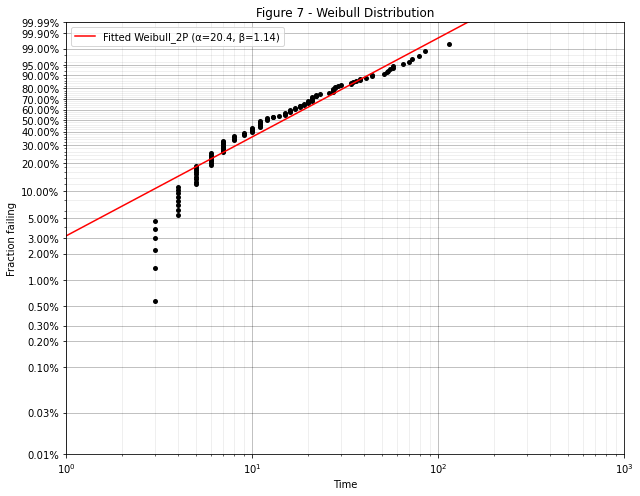

In [18]:
from reliability.Probability_plotting import Weibull_probability_plot

Weibull_probability_plot(failures=failure_times)

plt.title('Figure 7 - Weibull Distribution')
fig.set_size_inches(18.5, 10.5)

plt.show()

## 3.3 Fit models and estimate parameters.

First, we fit the Weibull model using the `reliability` package.

Results from Fit_Weibull_2P (95% CI):
           Point Estimate  Standard Error   Lower CI   Upper CI
Parameter                                                      
Alpha           21.317013        1.801491  18.063075  25.157125
Beta             1.122835        0.074321   0.986222   1.278371
Log-Likelihood: -492.5142516935074


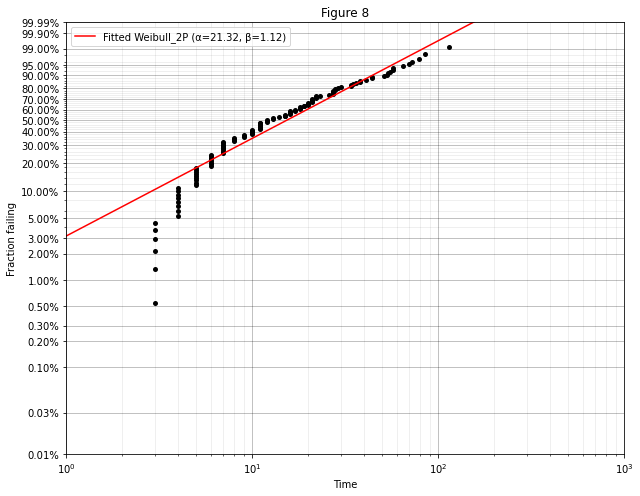

In [19]:
wbfit = rb.Fitters.Fit_Weibull_2P(failures=failure_times, 
                                   right_censored=right_censored_times)
plt.title("Figure 8")
plt.show()

This gives us the same probability plot and parameter estimations as before, but also includes estimates for the confidence intervals of the parameters.

The estimated parameters by this model are parameters $\hat{\alpha}$ (*$\hat{\eta}$ in the [R script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/)*) and $\hat{\beta}$ (*$\hat{\beta}$ in the [R script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/)*).

Our estimates for these parameters are very similar to what was obtained in the [R script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/)).


And how well does this fit the data? The `Fit_Weibull_2P` function already prints the plot when called, so we can visualise it above. We can see in that plot that beyond time 7 (approx.), the line fits the data relatively well. We may, however, achieve better results with a different distribution (Lognormal or Exponential).


For further information about this function type `help(rb.Fitters.Fit_Weibull_2P)`.

---

**Note**: I have yet to find a function that plots the joint uncertainty of the estimated Weibull model parameters as in the [R script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/) (Figure 9).

## 3.4 Inference

What can we learn about the reliability of this component or system from this fitted model?

Well, firstly, the value of $\hat{\beta}$= 1.12 is near 1, and the approximate 95% confidence interval for $\hat{\beta}$ of $[0.99, 1.12]$ contains 1, which suggests that there is neither evidence for failures predominantly occurring due to ageing or wearout effects (i.e., $\hat{\beta}$ is not high), nor due to early failures, such as may occur due to manufacturing defects (i.e., $\hat{\beta}$ is not low).

First, we'll plot the failure rate, or *hazard* function, $h(t)$,  which describes the likelihood of failure during the next time increment $(\text{i.e., } \frac{dR}{dt}=-h(t)R(t))$.

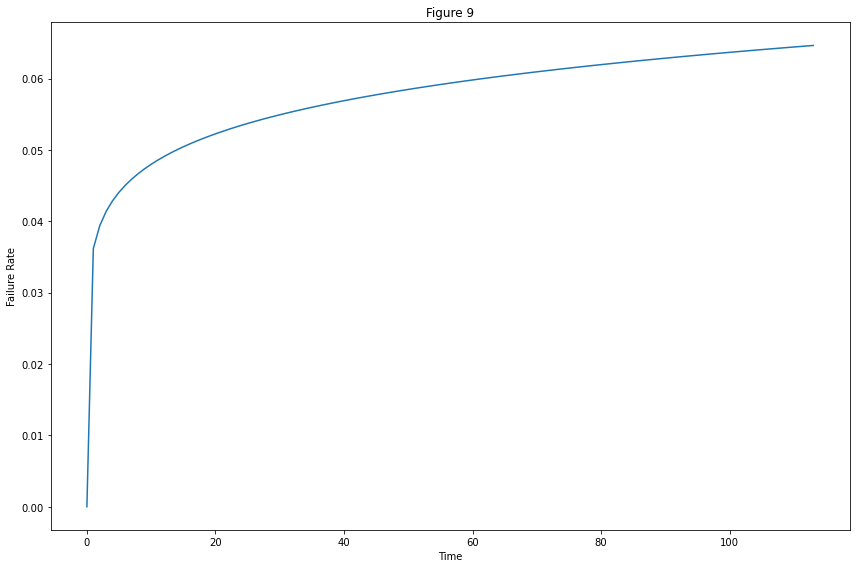

In [20]:
xvals = np.arange(0, max(failure_times))

rb.Distributions.Weibull_Distribution(alpha=wbfit.alpha, beta=wbfit.beta).HF(xvals=xvals)
plt.title("Figure 9")
plt.xlabel("Time")
plt.ylabel("Failure Rate")
plt.show()

As the $\hat{\beta}$ is only slightly above 1 and below 2, we knew that there was not a large increase in the failure rate with increasing time. A steeper increase in the hazard function occurs earlier, than later, in the life of this component or system (given model assumptions).

Next, we plot the Reliability function $R(t)$.

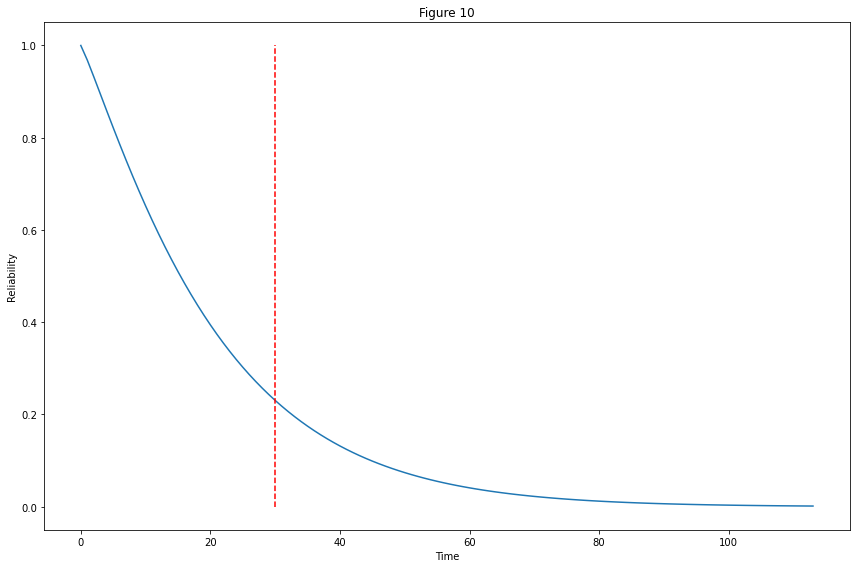

Reliability at time t=30: 0.23


In [21]:
xvals = np.arange(0, max(exa1['time']))

survival = rb.Distributions.Weibull_Distribution(alpha=wbfit.alpha, 
                                                 beta=wbfit.beta).SF(xvals=xvals)

plt.plot([30, 30], [0, 1], '--r')

plt.title("Figure 10")
plt.xlabel("Time")
plt.ylabel("Reliability")
plt.show()

print('Reliability at time t=30:', round(survival[30],3))

This shows the trend of Reliability (the probability that the component or system is still functioning at time $t$) with $t$, also know as the Survival Function.

As the `Weibull_Distribution` function returns an array of 'reliability' from *time=0* to a specified time, we can simply index that array at element 30 to find the value.

Next, we'll calculate the MTTF from the $\mathbb{E}[T]$ using $\hat{\beta}$ and $\hat{\eta}$. The `reliability` package doesn't have this feature yet, so we'll use the old `weibull` package.


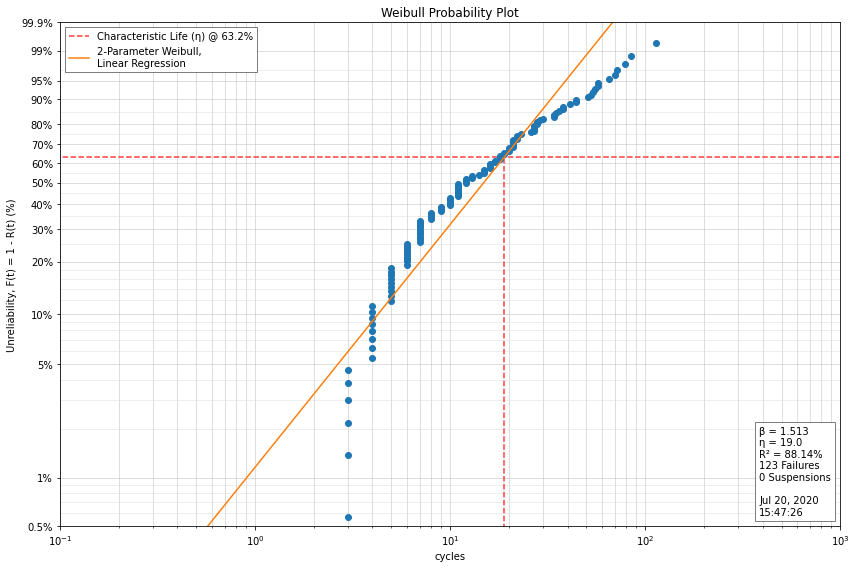

MTTF =  17.109


In [22]:
analysis = wb.Analysis(data=failure_times)

analysis.fit()

analysis.probplot()

print("MTTF = ", round(analysis.mttf,3))

Comparing this value to the [R Script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/) we can see that the `weibull` package is poor at fitting a Weibull distribution to this data set. We can however, use the parameter estimatations obtained from the `Fit_Weibull_2P` function to better estimate the *MTTF*:

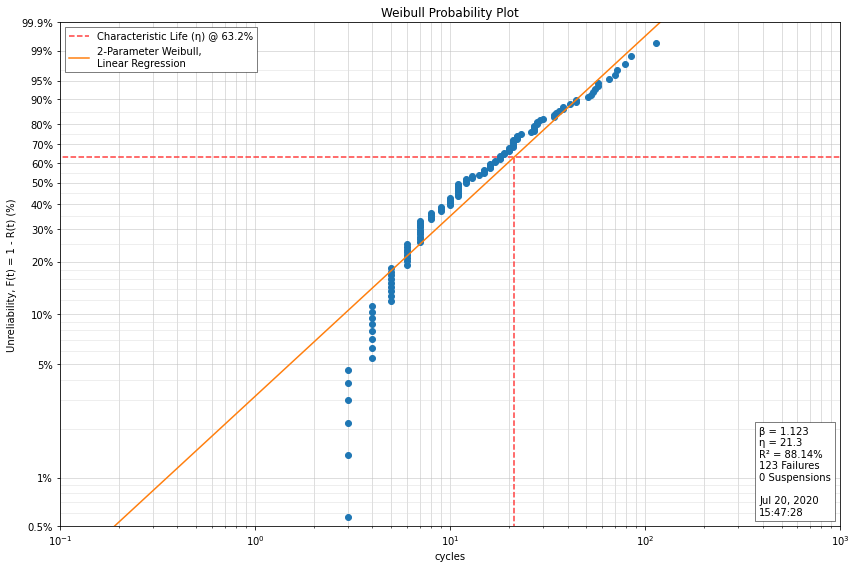

MTTF =  20.0 3


In [23]:
analysis = wb.Analysis(data=failure_times)

analysis.fit()

analysis.beta = wbfit.beta
analysis.eta = wbfit.alpha

analysis.probplot()

print("MTTF = ", round(analysis.mttf),3)

Which we can see is close to the value obtained in the [R Script](https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/).

In order to calculate the 95% Confidence intervals for MTTF we can obtain relatively accurate estimates using a computer-intensive method known as bootstrapping. On a standard laptop this may take 10-15 mins to run, so you may want to get a cup of tea before running …

There is no function to do bootstrapping in the `weibull` or `reliability` packages, so we'll bootstrap doing the following:
1. Sample with replacement from the original data set
2. Generate the values for $\hat{\beta}$ and $\hat{\eta}$ using the `reliability` package
3. Generate the MTTF value using the `weibull` package
4. Calculate the statistics for the MTTF

**Note**: the warning "the maximum likelihood method is likely to yield better results with {} data points" is automatic and I haven't found a solution to turn it off.

In [24]:
##For reproducibility
np.random.seed(123)

In [26]:
size = len(failure_times)
mttf_vals = []

for i in range(0, 10000):
    new_vals = np.random.choice(failure_times, size=size)
    parameters = rb.Fitters.Fit_Weibull_2P(failures=new_vals, 
                                           show_probability_plot=False, print_results=False)
    analysis = wb.Analysis(data=new_vals)
    analysis.fit()
    analysis.beta = parameters.beta
    analysis.eta = parameters.alpha
    
    mttf_vals.append(analysis.mttf)

In [27]:
ci = st.t.interval(0.95,df=len(mttf_vals)-1, loc=st.describe(mttf_vals).mean, 
                   scale = sqrt(st.describe(mttf_vals).variance))

print('minimum: ', round(st.describe(mttf_vals).minmax[0]),3)
print('lower 95% CI:', round(ci[0],3))
print('mean: ', round(st.describe(mttf_vals).mean,3))
print('upper 95% CI:', round(ci[1],3))
print('maximum: ', round(st.describe(mttf_vals).minmax[1],3))
print('variance: ', round(st.describe(mttf_vals).variance,3))


minimum:  14.0 3
lower 95% CI: 16.054
mean:  19.466
upper 95% CI: 22.878
maximum:  26.808
variance:  3.029


Compare the MTTF to an empirical estimate for the non-censored failures:

In [28]:
print(round(np.mean(failures['time']),3))

19.35


That this value is close to the Weibull MLE for $\mathbb{E}[T]$ likely reflects that there was a relatively small proportion of censored measurements in this dataset. 


Let's plot the estimated Weibull pdf of t, with $\mathbb{E}[T]$ superimposed as a vertical solid line, with the approximate 95% confidence bounds for $\mathbb{E}[T]$ shown as dashed lines.

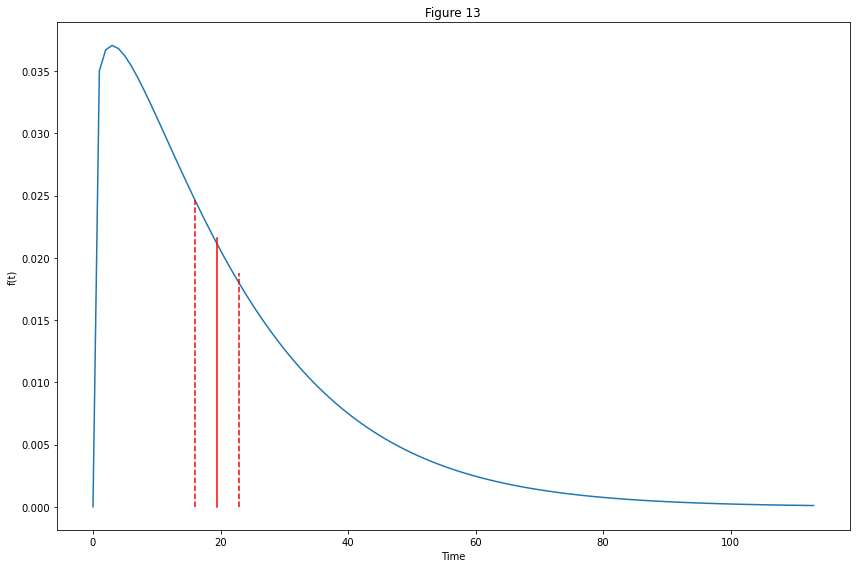

In [29]:
xvals = np.arange(0, max(failure_times))

wbfit = rb.Fitters.Fit_Weibull_2P(failures=failure_times, right_censored=right_censored_times,
                                   show_probability_plot=False, print_results=False)
pdf = rb.Distributions.Weibull_Distribution(alpha=wbfit.alpha, beta=wbfit.beta).PDF(xvals=xvals)

plt.plot([st.describe(mttf_vals).mean, st.describe(mttf_vals).mean], 
         [0, pdf[int(st.describe(mttf_vals).mean)]], '-r')
plt.plot([ci[0],ci[0]],[0, pdf[int(ci[0])] ], '--r')
plt.plot([ci[1],ci[1]],[0, pdf[int(ci[1])] ], '--r')


plt.title("Figure 13")
plt.xlabel("Time")
plt.ylabel("f(t)")
plt.show()


Compare this to Figure 5, a histogram of the non-censored time measurements. As it looks similar, and given the relatively small proportion of censored measurements in this dataset, this is further evidence to infer that this model has adequately captured the properties of this dataset. However, more formal tests could be conducted (see Meeker and Escobar, 1998). This also demonstrates that the Weibull distribution is quite flexible in that it can approximate the Exponential distribution (when $\beta=1$) as well as right-skewed and symmetric unimodal distributions. We can also see that the approximate 95% confidence interval for $E[T]$, our estimate of mean time to failure, is non-symmetrical, reflecting the skewed distribution of failure times.

---

Importantly, parameter estimates should be interpretted in context of knowledge of the system and of the sampled data. That is, do these results make sense? What does this mean for maintenance of this system?

---


# References cited

Abernethy, R. (2003) _The New Weibull Handbook_. 5th ed. Dr Robert Abernethy.

Genschel, U., Meeker, W.Q. (2010) A comparison of Maximum Likelihood and Median-Rank Regression for Weibull Estimation. _Quality Engineering_ **22**: 236-255.

Hodkiewicz, M., Ho, M. (2016) Cleaning historical maintenance work order data for reliability analysis. _Journal of Quality in Maintenance Engineering_ **2**(2): 146-163.

Ho, M.T. (2016) _A shared reliability database for mobile mining equipment_. Ph.D. thesis, University of Western Australia.

Marriott, R. (n.d.) _Reliability Analysis in R_. UWA System Health Lab. https://systemhealthlab.com/research-tools/example-of-a-reliability-analysis-in-r/

Meeker, W.Q., Escobar, A. (1998) _Statistical Methods for Reliability Data. Wiley series in probability and statistics. Applied probability and statistics_. John Wiley & Sons, Inc. Canada.

O’ Connor, P.T.D., Kleyner, A. (2012) _Practical Reliability Engineering_. 5th ed. John Wiley & Sons, Ltd. West Sussex, United Kingdom.